### Part 2 IV

### Tasks: compute flows between stations respectively based on 3 scenarios and conditions

#### 1. Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats
import numpy as np
from math import sqrt
import networkx as nx
import re
from shapely.geometry import Point, LineString #this library is for manipulating geometric objects, and it is what geopandas uses to store geometries
from scipy.spatial import distance
import json

#### 2. Self-defined functions

In [2]:
def CalcRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

#### 3. Import data and pre-processing the original data

In [3]:
OD_data = pd.read_csv("london_flows_OD.csv")
# OD_data.info()

# Remove Battersea Park station
Battersea_park = OD_data[(OD_data.station_origin == "Battersea Park") | (OD_data.station_destination == "Battersea Park")].index
OD_data_1 = OD_data.drop(Battersea_park)
# OD_data_1.info()

### Drop the flows and relevant information between same stations
# Create a new total column which excludes intra-borough flow totals (we will set them
#to a very small number, avoid NaN when creating pivot table later
OD_data_1["TotalNoIntra"] = OD_data_1.apply(lambda x: 0 if x['station_origin'] == x['station_destination'] else x['flows'], axis=1)
#set the number to a very small number
OD_data_1["offset"]= OD_data_1.apply(lambda x: 0.0000000001 if x['station_origin'] == x['station_destination'] else 0, axis=1)
OD_data_1["offset"].value_counts()#18行数据是自己到自己的
offset_sub = OD_data_1[OD_data_1.offset == 0.0000000001].index
OD_data_1 = OD_data_1.drop(offset_sub)
OD_data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61413 entries, 0 to 61473
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_origin       61413 non-null  object 
 1   station_destination  61413 non-null  object 
 2   flows                61413 non-null  int64  
 3   population           61413 non-null  int64  
 4   jobs                 61413 non-null  int64  
 5   distance             61413 non-null  float64
 6   TotalNoIntra         61413 non-null  int64  
 7   offset               61413 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 4.2+ MB


#### 4. 3 scenarios

#### 4.1 Prediction of Scenario A

In [4]:
#create a new job function to change the value with
#station_destination == "Canary Wharf" to 50% of original number of jobs
def new_jobs(row):
    if row["station_destination"] == "Canary Wharf":
        val = 0.5*row["jobs"]
    else:
        val = row["jobs"]
    return val

OD_data_1["jobsSA"] = OD_data_1.apply(new_jobs, axis =1)#applying to the data set
#check the result to make sure it has been applied
OD_data_1["jobsSA"] = OD_data_1["jobsSA"].astype(int)
OD_data_1.head()

,station_origin,station_destination,flows,population,jobs,distance,TotalNoIntra,offset,jobsSA
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0,0.0,78549
1,Abbey Road,Beckton,1,599,442,8510.121774,1,0.0,442
2,Abbey Road,Blackwall,3,599,665,3775.448872,3,0.0,665
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1,0.0,29386
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37,0.0,15428


In [5]:
#take the variables and produce logarithms of them
x_variables = ["population", "jobs","jobsSA", "distance"]
log_x_vars = []
for x in x_variables:
    OD_data_1[f"log_{x}"] = np.log(OD_data_1[x])
    log_x_vars.append(f"log_{x}")

#based on negative exponential cost function
#########destination-constrained model result###########
#create the formula (the "-1" indicates no intercept in the regression model).
formula = 'flows ~ station_origin + log_jobsSA + distance - 1'
#run a production constrained sim
prodSimSA = smf.glm(formula = formula, data=OD_data_1, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSimSA.summary())
#gamma: 0.7597; beta = 0.0002
## Compute the new flows for scenario A:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
O_i = pd.DataFrame(OD_data_1.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
OD_data_1 = OD_data_1.merge(O_i, on = "station_origin", how = "left" )
D_j = pd.DataFrame(OD_data_1.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
OD_data_1 = OD_data_1.merge(D_j, on = "station_destination", how = "left" )
# Pulling out the parameter values
coefs = pd.DataFrame(prodSimSA.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")
#then once you have done this you can join them back into the dataframes
OD_data_1 = OD_data_1.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
OD_data_1.drop(columns = ["coef"], inplace = True)
#check this has worked
OD_data_1.head()
# #add Oi Dj and alpha-i
alpha_i = prodSimSA.params[0:398]
gamma = prodSimSA.params[398]
beta = prodSimSA.params[399]
OD_data_1["prodsimest_SA"] = np.exp(OD_data_1["alpha_i"]+gamma*OD_data_1["log_jobsSA"]+beta*OD_data_1["distance"])
# Round the estimates
OD_data_1["prodsimest_SA"] = round(OD_data_1["prodsimest_SA"],0)
#now we can create a pivot tabel to turn the paired list into a matrix, and compute the margins as well
OD_data_1_SA = OD_data_1.pivot_table(values ="prodsimest_SA", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
OD_data_1_SA

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.2084e+05
Date:                Tue, 02 May 2023   Deviance:                   1.6695e+06
Time:                        04:15:11   Pearson chi2:                 2.50e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

C:\Users\zhaol\AppData\Local\Temp\ipykernel_3808\2995472245.py:31: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["coef"] = coefs["coef"].str.replace(x, "")


station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,597.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1225.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3749.0
Aldgate,NaN,NaN,1.0,NaN,38.0,NaN,NaN,0.0,NaN,28.0,...,2.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2882.0
Aldgate East,NaN,NaN,1.0,41.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,0.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3164.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,42.0,53.0,NaN,NaN,NaN,NaN,31.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4861.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,531.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3098.0


In [6]:
CalcRSquared(OD_data_1["flows"], OD_data_1["prodsimest_SA"])

0.4521822567684058

In [7]:
CalcRMSE(OD_data_1["flows"], OD_data_1["prodsimest_SA"])

97.621

In [8]:
#########doubly-constrained model result###########
#create the formula (the "-1" indicates no intercept in the regression model).
formula = 'flows ~ station_origin + station_destination + distance - 1'
#run a production constrained sim
doublySimSA = smf.glm(formula = formula, data=OD_data_1, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(doublySimSA.summary())
#beta = 0.0002
OD_data_1["doubsimfitted_SA"] = np.round(doublySimSA.mu,0)
OD_data_1_SA_doubly = OD_data_1.pivot_table(values ="doubsimfitted_SA", index="station_origin", columns = "station_destination",
                                    aggfunc=np.sum, margins=True)
OD_data_1_SA_doubly

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    60617
Model Family:                 Poisson   Df Model:                          795
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -8.5105e+05
Date:                Tue, 02 May 2023   Deviance:                   1.5299e+06
Time:                        04:15:47   Pearson chi2:                 2.02e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0,603.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1221.0
Acton Town,NaN,NaN,NaN,11.0,10.0,NaN,17.0,0.0,NaN,12.0,...,40.0,4.0,2.0,19.0,NaN,0.0,NaN,1.0,NaN,3752.0
Aldgate,NaN,NaN,1.0,NaN,32.0,NaN,NaN,0.0,NaN,23.0,...,7.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2883.0
Aldgate East,NaN,NaN,2.0,38.0,NaN,NaN,0.0,0.0,NaN,24.0,...,7.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,38.0,44.0,NaN,NaN,NaN,NaN,25.0,...,7.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,4862.0
Woodgrange Park,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,528.0
Woodside Park,NaN,NaN,2.0,17.0,15.0,NaN,0.0,NaN,NaN,25.0,...,10.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3093.0


In [9]:
CalcRSquared(OD_data_1["flows"],OD_data_1["doubsimfitted_SA"])

0.49784274146323326

In [10]:
CalcRMSE(OD_data_1["flows"],OD_data_1["doubsimfitted_SA"])

93.401

(0.0, 8000.0)

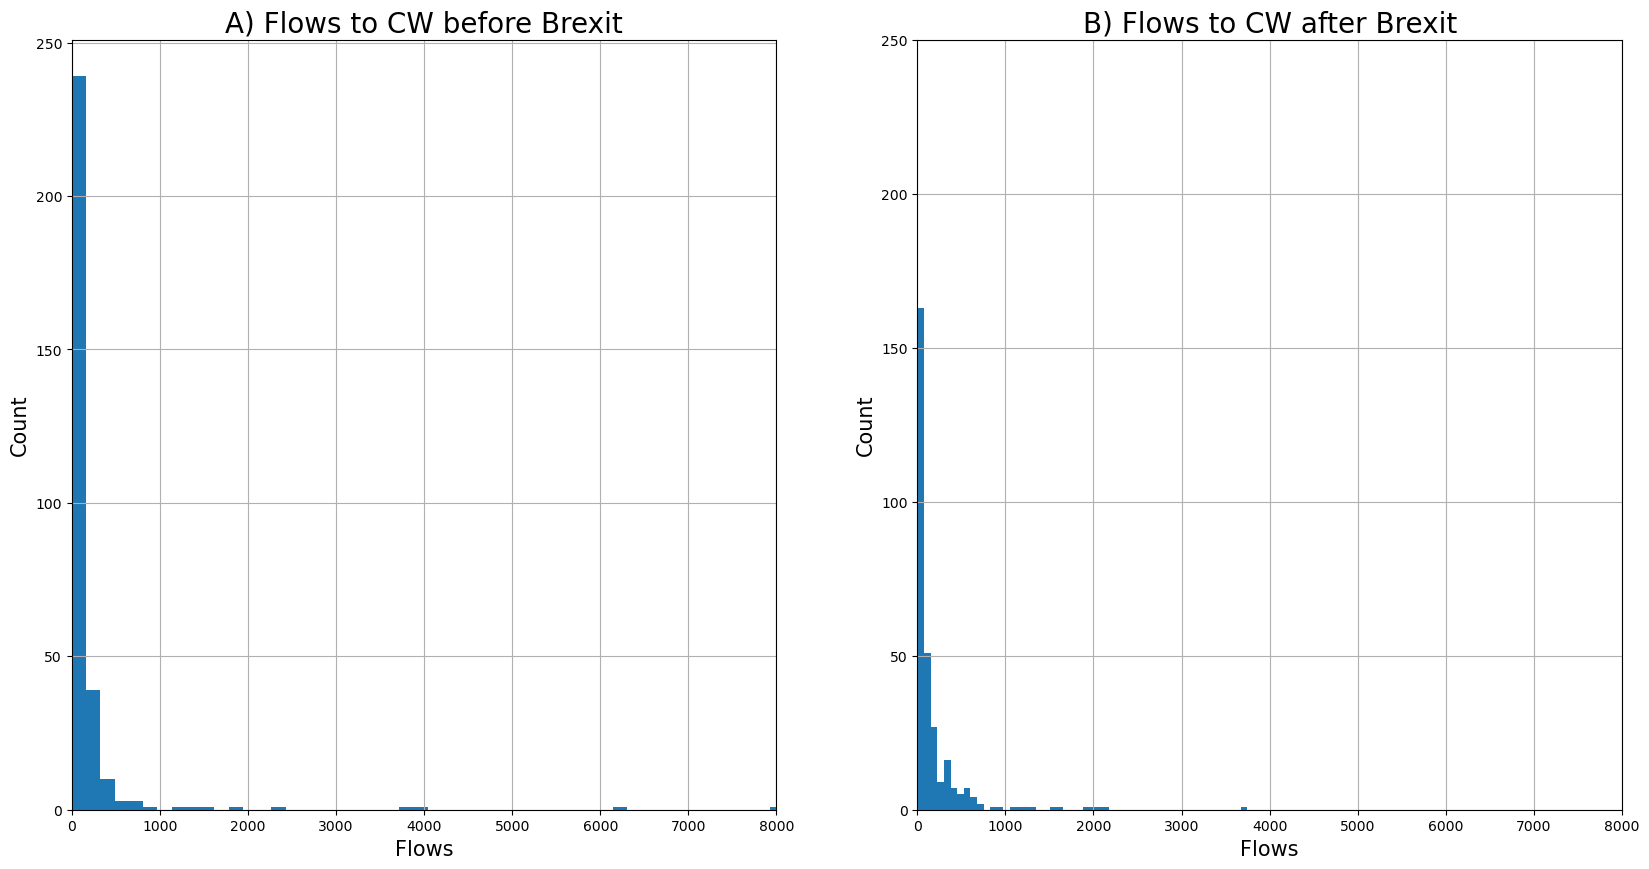

In [11]:
### histogram of flows to CW before and after Brexit
flow_to_CW = OD_data_1[OD_data_1.station_destination == "Canary Wharf"]

fig,axs = plt.subplots(1,2,figsize=(20,10))
axs[0].hist(flow_to_CW["flows"], histtype="stepfilled" , bins = 50)
axs[0].set_xlabel("Flows", fontsize = 15)
axs[0].set_ylabel("Count", fontsize= 15)
axs[0].set_title("A) Flows to CW before Brexit", fontsize = 20)
axs[0].grid(True)
axs[0].set_xlim(0,8000)

axs[1].hist(flow_to_CW["doubsimfitted_SA"], histtype="stepfilled" , bins = 50)
plt.xlabel("Flows", fontsize = 15)
plt.ylabel("Count", fontsize= 15)
plt.title("B) Flows to CW after Brexit", fontsize = 20)
plt.grid(True)
plt.ylim(0,250)
plt.xlim(0,8000)

(0.0, 3000.0)

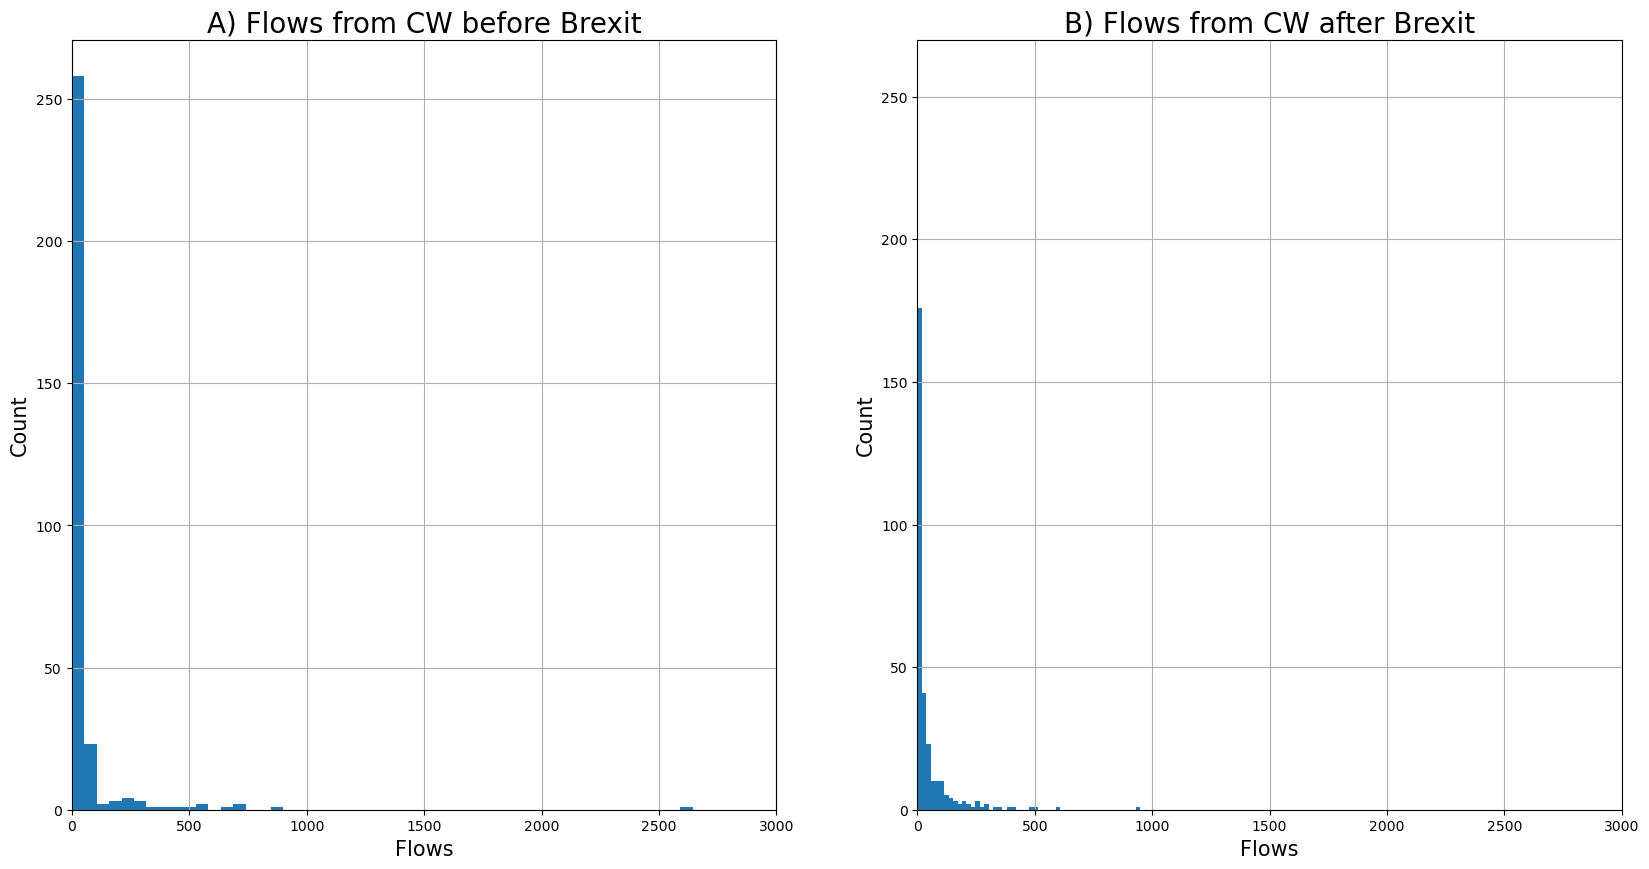

In [12]:
### histogram of flows to CW before and after Brexit
flow_from_CW = OD_data_1[OD_data_1.station_origin == "Canary Wharf"]

fig,axs = plt.subplots(1,2,figsize=(20,10))
axs[0].hist(flow_from_CW["flows"], histtype="stepfilled" , bins = 50)
axs[0].set_xlabel("Flows", fontsize = 15)
axs[0].set_ylabel("Count", fontsize= 15)
axs[0].set_title("A) Flows from CW before Brexit", fontsize = 20)
axs[0].grid(True)
axs[0].set_xlim(0,3000)

axs[1].hist(flow_from_CW["doubsimfitted_SA"], histtype="stepfilled" , bins = 50)
plt.xlabel("Flows", fontsize = 15)
plt.ylabel("Count", fontsize= 15)
plt.title("B) Flows from CW after Brexit", fontsize = 20)
plt.grid(True)
plt.ylim(0,270)
plt.xlim(0,3000)

#### 4.2 Prediction of Scenario B

In [13]:
#### cost of transport growth by multiple
OD_data_1

,station_origin,station_destination,flows,population,jobs,distance,TotalNoIntra,offset,jobsSA,log_population,log_jobs,log_jobsSA,log_distance,O_i,D_j,alpha_i,prodsimest_SA,doubsimfitted_SA
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,0,0.0,78549,6.395262,11.271478,11.271478,9.003504,599,78549,-2.887913,84.0,77.0
1,Abbey Road,Beckton,1,599,442,8510.121774,1,0.0,442,6.395262,6.091310,6.091310,9.049012,599,442,-2.887913,2.0,3.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,3,0.0,665,6.395262,6.499787,6.499787,8.236275,599,665,-2.887913,4.0,4.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1,0.0,29386,6.395262,10.981421,10.288274,8.534348,599,58772,-2.887913,63.0,112.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37,0.0,15428,6.395262,9.643939,9.643939,7.709274,599,15428,-2.887913,60.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,127,0.0,3342,8.973605,8.114325,8.114325,9.503144,7892,3342,0.555605,107.0,185.0
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,608,0.0,5487,8.973605,8.610137,8.610137,9.071245,7892,5487,0.555605,319.0,176.0
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,6,0.0,400,8.973605,5.991465,5.991465,9.162905,7892,400,0.555605,38.0,27.0
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,81,0.0,893,8.973605,6.794587,6.794587,8.585832,7892,893,0.555605,134.0,132.0


In [14]:
# destination-constrained model
#create the formula (the "-1" indicates no intercept in the regression model).
attr_form = 'flows ~ station_destination + log_population + log_distance - 1'
#run a production constrained sim
Sim_B = smf.glm(formula = attr_form, data=OD_data_1, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(Sim_B.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1646e+06
Date:                Tue, 02 May 2023   Deviance:                   2.1570e+06
Time:                        04:16:01   Pearson chi2:                 3.65e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [15]:
alpha_des = Sim_B.params[-2]
gamma_i = Sim_B.params[0:397]
beta_des_B1 = 1

# Merge parameters in the dataframe
coefs_des_B = pd.DataFrame(Sim_B.params)
coefs_des_B.reset_index(inplace=True)
coefs_des_B.rename(columns = {0:"gamma_i", "index":"coef"}, inplace = True)
to_repl = ["(station_destination)", "\[", "\]"]
for x in to_repl:
    coefs_des_B["coef"] = coefs_des_B["coef"].str.replace(x, "")
coefs_des_B
OD_data_1 = OD_data_1.merge(coefs_des_B, left_on="station_destination", right_on="coef", how = "left")
OD_data_1.drop(columns = ["coef"], inplace = True)
#check this has worked
OD_data_1["des_constrainedEst_B1"] = np.exp(alpha_des*OD_data_1["log_population"] + OD_data_1["gamma_i"]
                                       - beta_des_B1*OD_data_1["log_distance"]) #prediction flows
OD_data_1["des_constrainedEst_B1"] = np.round(OD_data_1["des_constrainedEst_B1"],0)
#turn it into a little matrix and have a look at your handy work
OD_data_1_des_B1 = OD_data_1.pivot_table(values ="des_constrainedEst_B1", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
OD_data_1_des_B1

C:\Users\zhaol\AppData\Local\Temp\ipykernel_3808\1412560136.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs_des_B["coef"] = coefs_des_B["coef"].str.replace(x, "")


station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,31.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,13.0
Acton Town,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,1.0,...,1.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,98.0
Aldgate,NaN,NaN,0.0,NaN,4.0,NaN,NaN,0.0,NaN,2.0,...,1.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,NaN,291.0
Aldgate East,NaN,NaN,0.0,5.0,NaN,NaN,0.0,0.0,NaN,2.0,...,1.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,290.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,78.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
Woodside Park,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,46.0


In [16]:
beta_des_B2 = 1.5
OD_data_1["des_constrainedEst_B2"] = np.exp(alpha_des*OD_data_1["log_population"] + OD_data_1["gamma_i"]
                                       - beta_des_B2*OD_data_1["log_distance"]) #prediction flows
OD_data_1["des_constrainedEst_B2"] = np.round(OD_data_1["des_constrainedEst_B2"],0)
#turn it into a little matrix and have a look at your handy work
OD_data_1_des_B2 = OD_data_1.pivot_table(values ="des_constrainedEst_B2", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
OD_data_1_des_B2

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0
Acton Town,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,...,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,NaN,3.0
Aldgate East,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
Woodside Park,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [17]:
OD_data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61413 entries, 0 to 61412
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   station_origin         61413 non-null  object 
 1   station_destination    61413 non-null  object 
 2   flows                  61413 non-null  int64  
 3   population             61413 non-null  int64  
 4   jobs                   61413 non-null  int64  
 5   distance               61413 non-null  float64
 6   TotalNoIntra           61413 non-null  int64  
 7   offset                 61413 non-null  float64
 8   jobsSA                 61413 non-null  int32  
 9   log_population         61413 non-null  float64
 10  log_jobs               61413 non-null  float64
 11  log_jobsSA             61413 non-null  float64
 12  log_distance           61413 non-null  float64
 13  O_i                    61413 non-null  int64  
 14  D_j                    61413 non-null  int64  
 15  al

In [18]:
OD_data_1[(OD_data_1.station_origin == 'Burnt Oak') & (OD_data_1.station_destination == 'Edgware')]

,station_origin,station_destination,flows,population,jobs,distance,TotalNoIntra,offset,jobsSA,log_population,...,log_jobsSA,log_distance,O_i,D_j,alpha_i,prodsimest_SA,doubsimfitted_SA,gamma_i,des_constrainedEst_B1,des_constrainedEst_B2
7616,Burnt Oak,Edgware,72,3021,772,1518.129679,72,0.0,772,8.013343,...,6.648985,7.325234,3021,772,-1.085124,42.0,106.0,1.35979,1.0,0.0


## build a network

In [19]:
G = nx.read_graphml('london.graph')

# add edge(Scenario B-2 flows):
ScenarioB2_flows = {(u,v): 0 for u,v in G.edges()} #start and end of each edge
ScenarioB1_flows = {(u,v): 0 for u,v in G.edges()}
ScenarioA_flows = {(u,v): 0 for u,v in G.edges()}
#calculate shortest paths for all flows and add data to dict
for i, row in OD_data_1.iterrows():
    source = row.station_origin
    target = row.station_destination
    
    #get shortest path
    path = nx.dijkstra_path(G, source, target)
    
    #our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path,path[1:])) 
    
    #add flows to our dict
    for u,v in path_edges:
        try:
            ScenarioB2_flows[(u,v)] += row.des_constrainedEst_B2 # add attributes of edge keys to our destination matrix dictionary
            ScenarioB1_flows[(u,v)] += row.des_constrainedEst_B1
            ScenarioA_flows[(u,v)] += row.prodsimest_SA
        except:
            ScenarioB2_flows[(v,u)] += row.des_constrainedEst_B2
            ScenarioB1_flows[(v,u)] += row.des_constrainedEst_B1
            ScenarioA_flows[(v,u)] += row.prodsimest_SA
#set this as a network attribute
nx.set_edge_attributes(G, ScenarioB2_flows, 'scenario_B2_flows')
nx.set_edge_attributes(G, ScenarioB1_flows, 'scenario_B1_flows')
nx.set_edge_attributes(G, ScenarioA_flows, 'scenario_A_flows')

In [20]:
row.des_constrainedEst_B1

1.0

In [21]:
# To check edges attributes:
list(G.edges(data = True))[0]

('Edgware',
 'Burnt Oak',
 {'length': 1518.1296788637032,
  'line_name': 'Northern',
  'flows': 4177,
  'scenario_B2_flows': 0.0,
  'scenario_B1_flows': 51.0,
  'scenario_A_flows': 3688.0})

In [22]:
import pandas as pd
import networkx as nx

# Create an empty graph
G = nx.Graph()
# Read in the OD matrix file
OD_matrix = OD_data_1.copy()
# Add the nodes to the graph
nodes = set(OD_matrix['station_origin']) | set(OD_matrix['station_destination'])
for node in nodes:
    G.add_node(node)

# Add flow values as edge attributes to the graph
for index, row in OD_matrix.iterrows():
    origin = row['station_origin']
    dest = row['station_destination']
    flow_B2 = row['des_constrainedEst_B2']
    G.add_edge(origin, dest, flow=flow_B2)



NameError: name 'pos' is not defined

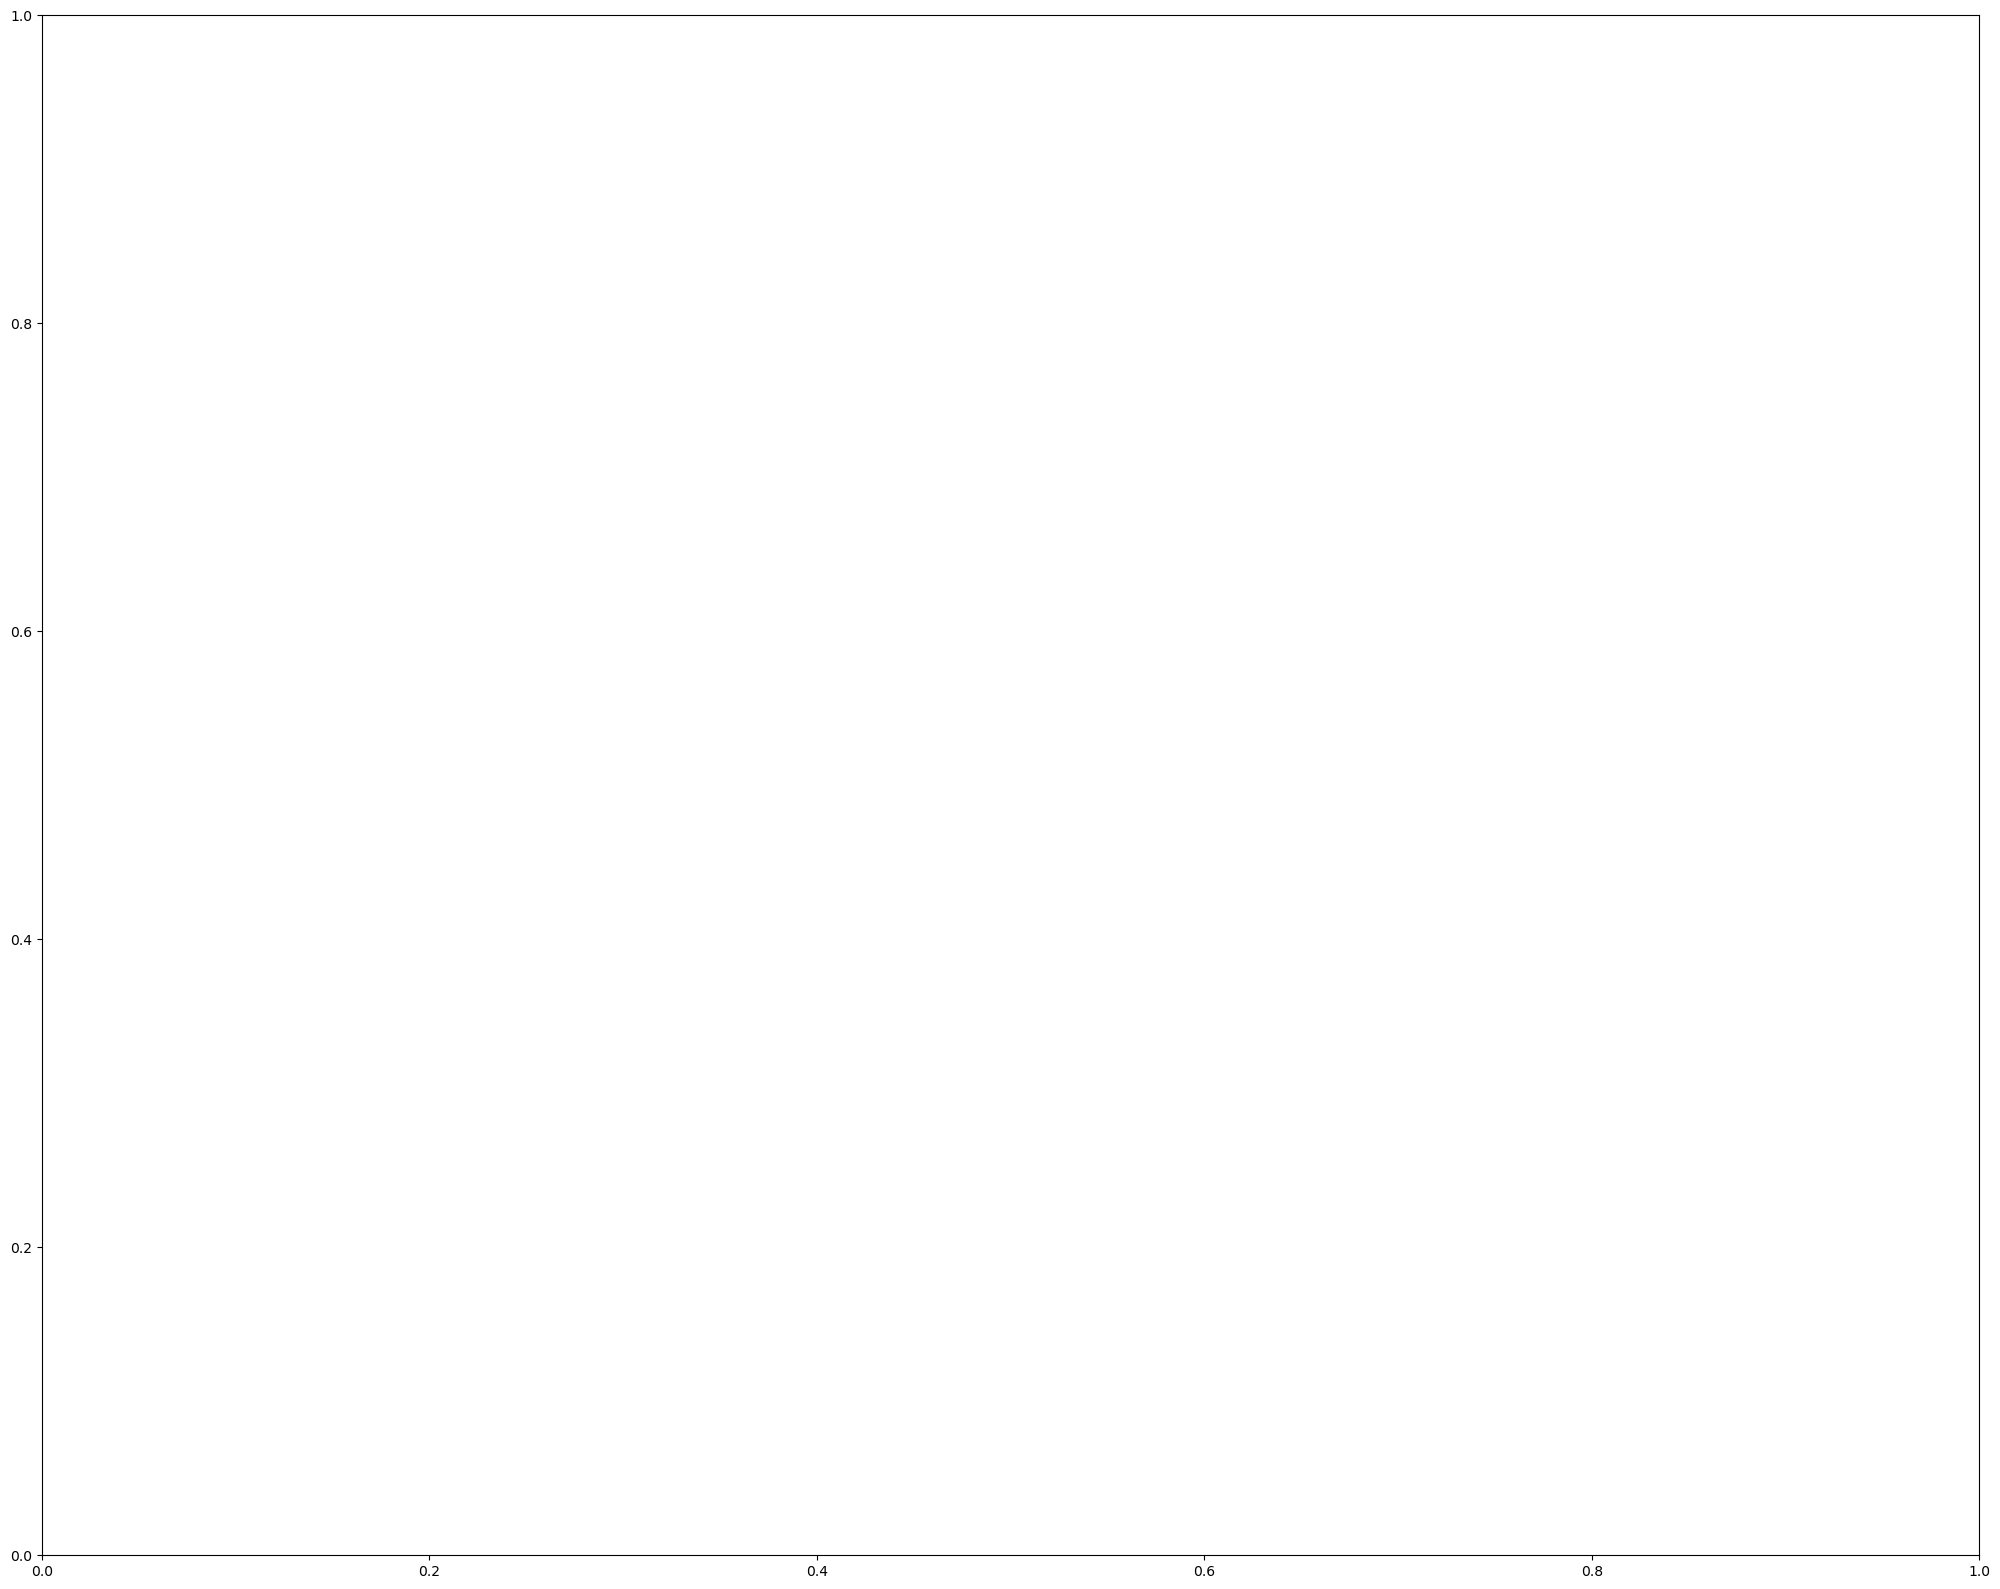

In [23]:
import matplotlib.pyplot as plt

# Visualize the network with edge thickness proportional to the flow
fig, ax = plt.subplots(figsize=(25,20))

node_labels = nx.get_node_attributes(G, 'station_origin')

# pos = nx.get_node_attributes(G, 'coords')

nx.draw_networkx_nodes(G,pos,node_size=50,node_color='b')
nx.draw_networkx_edges(G,pos,arrows=False,width=0.2)
nx.draw_networkx_labels(G,pos, node_labels, font_size=10, font_color='black')

plt.title("London tube network flows",fontsize=15)
plt.axis("off")
plt.show()

In [ ]:
# # Scenario A flow distribution plot
# flows_values = flows.values()
# flow_color=[(i[2]['flows']/max(flows_values)) for i in G.edges(data=True)]
# flow_width=[(i[2]['flows']/max(flows_values)*10) for i in G.edges(data=True)]


# # Plot graph
# fig, ax = plt.subplots(figsize=(12,12))

# #pos=nx.spring_layout(X)
# edg=nx.draw_networkx_edges(G, pos,edge_color=flow_color, width=flow_width)

# nx.draw_networkx_nodes(G,
#         pos = pos,
#         node_color= 'black',
#         node_size= 1)

# plt.colorbar(edg,label="Passenger Flows",orientation="horizontal", shrink=0.5)
# plt.axis("off")
# plt.title("London network Passenger Flows",fontsize=15)
# plt.show()

In [ ]:
# Scenario B-1 flow distribution plot


In [ ]:
# Scenario B-2 flow distribution plot
